In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras import layers
from sklearn import utils
from pymystem3 import Mystem
from string import punctuation
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from simple_elmo import ElmoModel
from tensorflow.keras import activations
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrysalis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read books

In [2]:
#dummy stub
first_author_name = "Nekrasov"
second_author_name = "Pushkin"

#appending all books of an author into books_first, books_second
def read_books(author_name):
    books_text = ""
    for book_name in os.listdir(f"./books_ru/poems/{author_name}"):
        book_file = open(f"./books_ru/poems/{author_name}/{book_name}", "r", encoding='utf8', errors='replace')
        books_text += " " + book_file.read()
        book_file.close()
    return books_text

books_first = read_books(first_author_name)
books_second = read_books(second_author_name)

author_1 = pd.DataFrame({"Author": [first_author_name], "label": 0, "Text": [books_first]})
author_2 = pd.DataFrame({"Author": [second_author_name], "label": 1, "Text": [books_second]})

author_1.head()

,Author,label,Text
0,Nekrasov,0,Николай Некрасов\nВ ДОРОГЕ\n«Скучно! скучно!....


In [3]:
author_2.head()

,Author,label,Text
0,Pushkin,1,Александр Пушкин\n19 ОКТЯБРЯ\nРоняет лес багр...


Clean text from punctuation

In [4]:
russian_stopwords = stopwords.words('russian')
mystem = Mystem()


#Preprocess function

def preprocess_text(text):
    text = re.sub(r'[^ЁёА-я\s]', ' ', text)
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = re.sub(r' {2,}', ' ', text)

    lemmas = mystem.lemmatize(text.lower())
    tokens = [token for token in lemmas if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text


author_1['Text'][0] = preprocess_text(author_1['Text'][0])
author_2['Text'][0] = preprocess_text(author_2['Text'][0])
authors = [author_1, author_2]

author_1.head()

C:\Users\CHRYSA~1\AppData\Local\Temp/ipykernel_10904/2939638234.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_1['Text'][0] = preprocess_text(author_1['Text'][0])
C:\Users\CHRYSA~1\AppData\Local\Temp/ipykernel_10904/2939638234.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_2['Text'][0] = preprocess_text(author_2['Text'][0])


,Author,label,Text
0,Nekrasov,0,николай некрасов дорога скучно скучно ямщик уд...


In [5]:
author_2.head()

,Author,label,Text
0,Pushkin,1,александр пушкин октябрь ронять лес багряный с...


VISUALIZING THE DATA

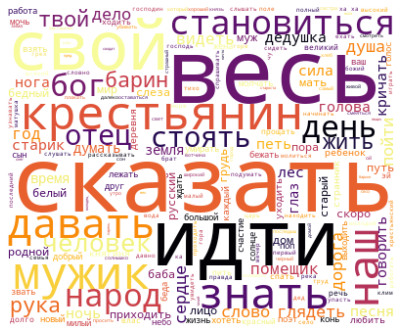

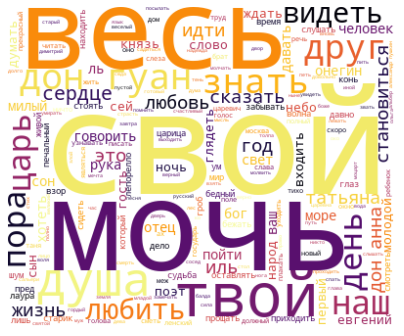

In [6]:
#cmaps=['viridis', 'plasma', 'inferno', 'magma', 'cividis']
for book in authors:
    wordcloud = WordCloud(background_color="white",
                          stopwords=russian_stopwords,
                          mode="RGBA",
                          width=400,
                          height=330,
                          colormap='inferno').generate(book['Text'][0])
    # Display the generated image:
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Count and visualize as barplots

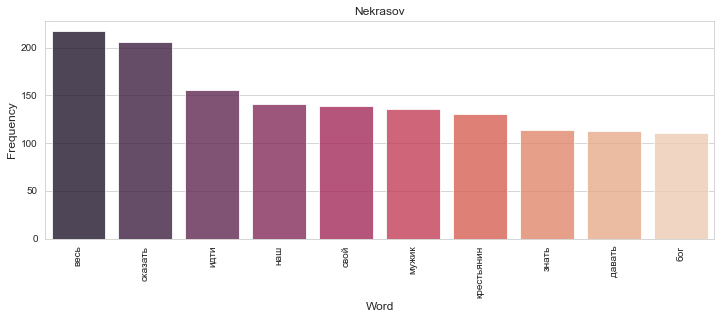

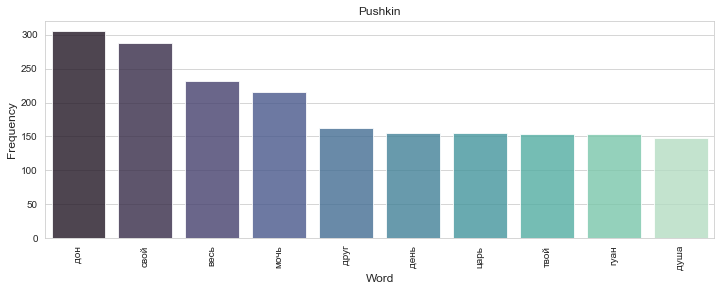

In [7]:
from collections import Counter

sns_palette = ["rocket", "mako", "magma", "rocket_r"]
sns.set_style("whitegrid")
for i, book in enumerate(authors):
    cnt_pro = np.asarray(Counter(book['Text'][0].split()).most_common(10))
    occ_df = pd.DataFrame({'word': cnt_pro[:, 0], 'count': [int(num) for num in cnt_pro[:, 1]]})
    plt.figure(figsize=(12, 4))
    sns.barplot(x='word', y='count', alpha=0.8, data=occ_df, palette=sns_palette[i])
    plt.title(book['Author'][0])
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Word', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

d:\study\semester 9\gan_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


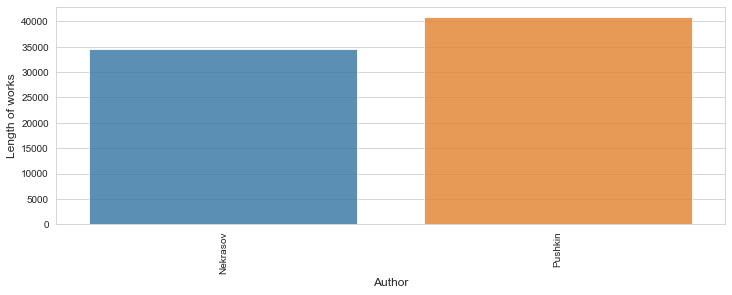

In [8]:
plt.figure(figsize=(12,4))
words = []
names = []
for book in authors:
    words.append(len(book['Text'][0].split()))
    names.append(book['Author'][0])

sns.barplot(names, words, alpha=0.8)
plt.ylabel('Length of works', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
dataset = pd.DataFrame(columns=['Author', 'Text', 'Vector'])
for author in authors:
    words = author['Text'][0].split()
    chunks = [words[i - 40:i] for i in range(40, len(words), 40)]
    temp_df = pd.DataFrame({'Author': author['Author'][0], 'label': author['label'][0], 'Text': chunks})
    dataset = dataset.append(temp_df)

dataset


,Author,Text,Vector,label
0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям...",NaN,0.0
1,Nekrasov,"[варган, играть, читать, весь, дворянский, ман...",NaN,0.0
2,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых...",NaN,0.0
3,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ...",NaN,0.0
4,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р...",NaN,0.0
...,...,...,...,...
1015,Pushkin,"[таилася, угасать, пламень, страстный, веселие...",NaN,1.0
1016,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать...",NaN,1.0
1017,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ...",NaN,1.0
1018,Pushkin,"[подлец, попович, красовский, пропускать, алек...",NaN,1.0


In [10]:
elmo = ElmoModel()
elmo.load("./212/", max_batch_size=40)

2021-11-06 15:25:39,149 : INFO : Loading model from ./212/...
2021-11-06 15:25:39,150 : INFO : We will cache the vocabulary of 100 tokens.
d:\study\semester 9\gan_env\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
d:\study\semester 9\gan_env\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


'The model is now loaded.'

In [11]:
authors_embeddings = elmo.get_elmo_vector_average(list(dataset['Text']))
authors_embeddings.shape

2021-11-06 15:25:47,066 : INFO : Warming up ELMo on 40 sentences...
2021-11-06 15:25:50,369 : INFO : Warming up finished.
2021-11-06 15:25:50,376 : INFO : Texts in the current batch: 40
2021-11-06 15:25:50,501 : INFO : Texts in the current batch: 40
2021-11-06 15:25:50,625 : INFO : Texts in the current batch: 40
2021-11-06 15:25:50,750 : INFO : Texts in the current batch: 40
2021-11-06 15:25:50,874 : INFO : Texts in the current batch: 40
2021-11-06 15:25:50,997 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,122 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,246 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,365 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,499 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,628 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,758 : INFO : Texts in the current batch: 40
2021-11-06 15:25:51,878 : INFO : Texts in the current batch: 40
2021-11-06 15:25:52,003 : INFO : Texts in the 

(1884, 1024)

In [12]:
dataset['Vector'] = authors_embeddings.tolist()
dataset

,Author,Text,Vector,label
0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям...","[-0.011470139721366502, -0.0106322402027096, 0...",0.0
1,Nekrasov,"[варган, играть, читать, весь, дворянский, ман...","[-0.03810712031372803, -0.008091613590381802, ...",0.0
2,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых...","[-0.007110398789843435, -0.05651810272176439, ...",0.0
3,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ...","[0.005119083138813237, -0.030656960150992597, ...",0.0
4,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р...","[0.00890367042616806, -0.04792607809479534, 0....",0.0
...,...,...,...,...
1015,Pushkin,"[таилася, угасать, пламень, страстный, веселие...","[-0.0053393848694948155, 0.02358813995839303, ...",1.0
1016,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать...","[0.016709924014217763, 0.02357823589043021, 0....",1.0
1017,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ...","[-0.008015237272020104, -0.036397945600639726,...",1.0
1018,Pushkin,"[подлец, попович, красовский, пропускать, алек...","[0.006709357940191536, 0.01828041133611132, 0....",1.0


In [20]:
X = np.asarray(dataset['Vector'].tolist())
Y = np.asarray(dataset['label'].tolist())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

pd.DataFrame({'Train': [X_train.shape, Y_train.shape], 'Test': [X_test.shape, Y_test.shape]}, index=['X', 'Y'])

,Train,Test
X,"(1601, 1024)","(283, 1024)"
Y,"(1601,)","(283,)"


In [63]:
# init layer
input_shape = layers.Input(shape=X_train.shape)

left = layers.Conv1D(200, kernel_size=3, use_bias=True)(input_shape)
#tower_1 = layers.MaxPooling2D(3)(tower_1)
left = layers.GlobalMaxPooling1D()(left)

middle = layers.Conv1D(200, kernel_size=4, use_bias=True)(input_shape)
#tower_2 = layers.MaxPooling2D(3)(tower_2)
middle = layers.GlobalMaxPooling1D()(middle)

right = layers.Conv1D(200, kernel_size=5, use_bias=True)(input_shape)
#tower_3 = layers.MaxPooling2D(3)(tower_3)
right = layers.GlobalMaxPooling1D()(right)

merged = layers.Concatenate(axis=1)([left, middle, right])

model = layers.Dense(6, activation='relu')(merged)
#model = layers.Activation(activations.relu)(merged)
#model = layers.Dropout(rate=.5)(model)
model = layers.Dense(3, activation=layers.Dropout(rate=.5))(model)
model = layers.Dense(3, activation='softmax')(model)
#model = layers.Softmax()(model)

cnn = Model(inputs=input_shape, outputs=model, name="cnn")

print(cnn.summary(line_length=140))

Model: "cnn"
____________________________________________________________________________________________________________________________________________
Layer (type)                                  Output Shape                   Param #         Connected to                                   
input_10 (InputLayer)                         [(None, 1601, 1024)]           0                                                              
____________________________________________________________________________________________________________________________________________
conv1d_25 (Conv1D)                            (None, 1599, 200)              614600          input_10[0][0]                                 
____________________________________________________________________________________________________________________________________________
conv1d_26 (Conv1D)                            (None, 1598, 200)              819400          input_10[0][0]                                 


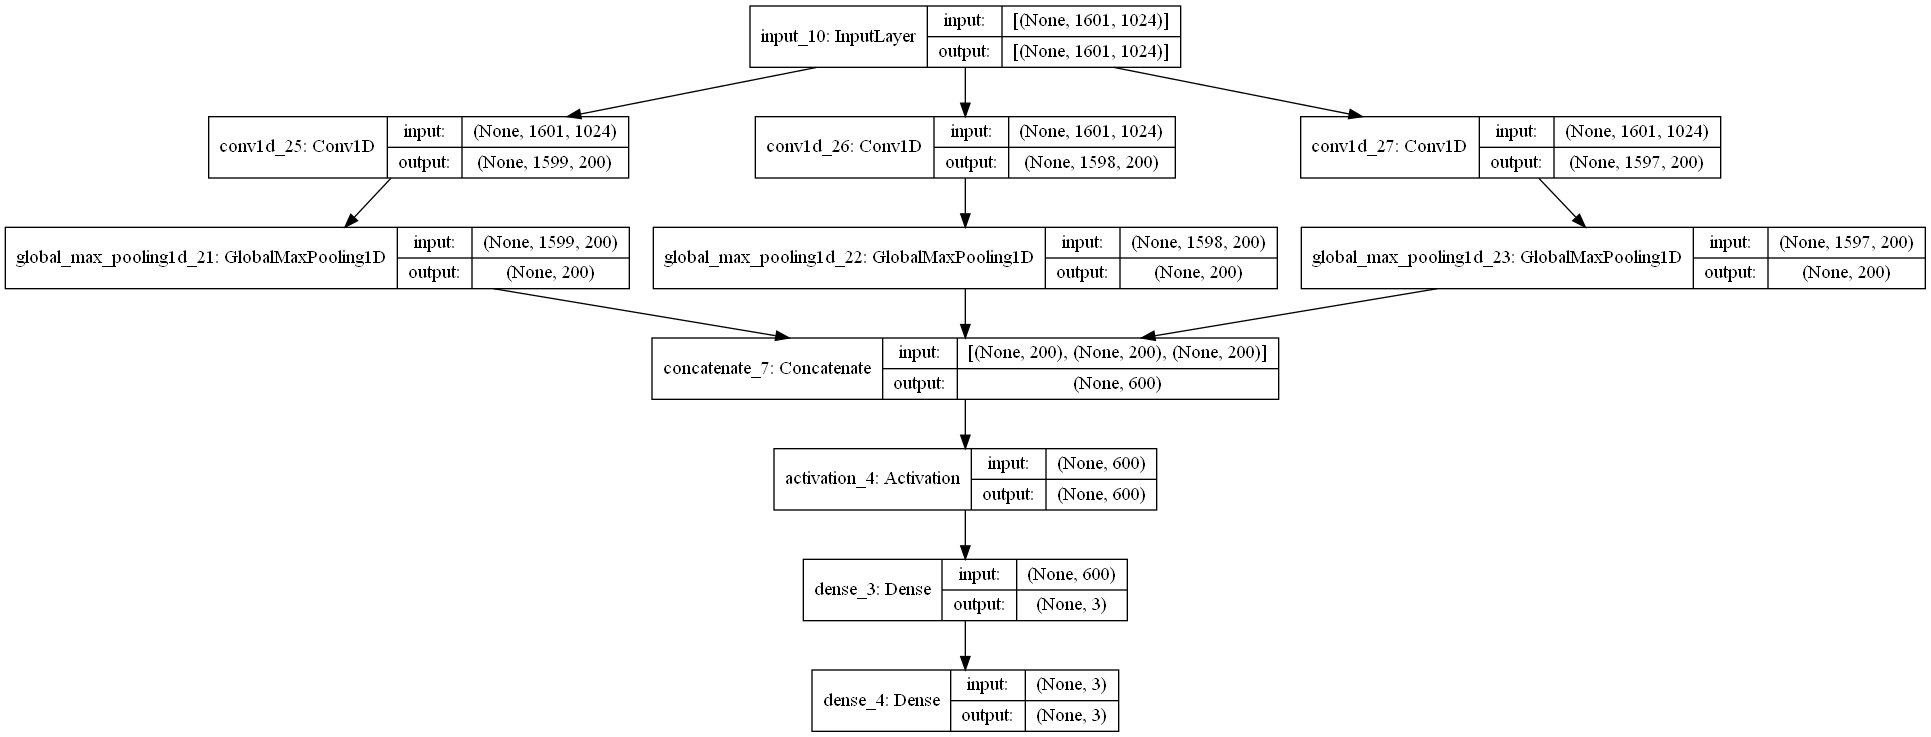

In [64]:
plot_model(cnn, "cnn.png", show_shapes=True)

In [53]:
#cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
cnn.compile(optimizer="adam",  loss="categorical_crossentropy", metrics=['acc'])

In [54]:
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_train_reshaped.shape

(1601, 1024, 1)

In [55]:
Y_train_reshaped = np.expand_dims(Y_train, axis=-1)
Y_train_reshaped.shape

(1601, 1)

In [56]:
output = cnn.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=2)
output

ValueError: Error when checking input: expected input_5 to have 3 dimensions, but got array with shape (1601, 1024)

In [ ]:
bilstm = Sequential()
forward_layer = layers.LSTM(40, return_sequences=True)
backward_layer = layers.LSTM(40, return_sequences=True, go_backwards=True)
bilstm.add(layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
bilstm.add(layers.Dropout(.5))
bilstm.add(layers.Activation(activations.relu))
bilstm.add(layers.Softmax())

# output model skeleton
print(bilstm.summary())
plot_model(bilstm, "bilstm.png", show_shapes=True)

In [35]:
#bilstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
#bilstm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['acc'])


NameError: name 'bilstm' is not defined

In [ ]:
merged = layers.Concatenate(axis=0)([cnn, bilstm])
cnn_bilstm = Model(inputs=input_shape, outputs=merged, name="cnn_bilstm")
print(cnn_bilstm.summary())
plot_model(cnn_bilstm, "merged.png", show_shapes=True)

In [ ]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)  #  model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

In [ ]:
import numpy as np

rounded_labels = np.argmax(Y_test, axis=1)
rounded_labels

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(rounded_labels, yhat_classes)
cm

In [ ]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [ ]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score, acc = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)

print("score: %.2f" % score)
print("acc: %.2f" % acc)

**Save Model**

In [ ]:
model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    '@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    'The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])